In [9]:
import glob as glob
import utils

## Hyperparameters and Constants


In [25]:
TRAIN = False
# Number of epochs to train for.
EPOCHS = 15

dataset = "../datasets/visDrone"
yolov5sDir = "runs/train/yolov5s_visDrone_15epochs"
yolov5mDir = "runs/train/yolov5m_visDrone_15epochs"
#/weights/best.pt


## Download and Prepare the Dataset

In [21]:
!git clone "https://github.com/ultralytics/yolov5"
%cd yolov5
%pip install -qr requirements.txt 

c:\Ablage\Master\DeepVision\Studienarbeit\yolov5-vs-rcnn\yolov5


In [12]:
import matplotlib.pyplot as plt
import cv2
# from PIL import Image
import torch
import torchvision
import os, random

c:\Users\Tobias\anaconda3\envs\dv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
print(torch.__version__)
print(torchvision.__version__)

1.11.0+cu113
0.12.0+cu113


### Visualize a Few Ground Truth Images

Before moving forward, let's check out few of the ground truth images. 

The current annotations in the text files are in normalized `[x_center, y_center, width, height]` format. Let's write a function that will convert it back to `[x_min, y_min, x_max, y_max]` format.

In [14]:
class_names = [
    'pedestrian', 'people', 'bicycle', 'car', 'van', 'truck', 'tricycle', 'awning-tricycle', 'bus', 'motor'
] 

In [19]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=4
        ) 
        cv2.putText(
            image, 
            class_names[int(labels[box_num])],
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 255, 0),
            2
        )
    return image

# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()
    
    plt.figure(figsize=(21, 12))
    for i in range(num_samples):
        image = cv2.imread(all_training_images[i+10])
        with open(all_training_labels[i+10], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.show()

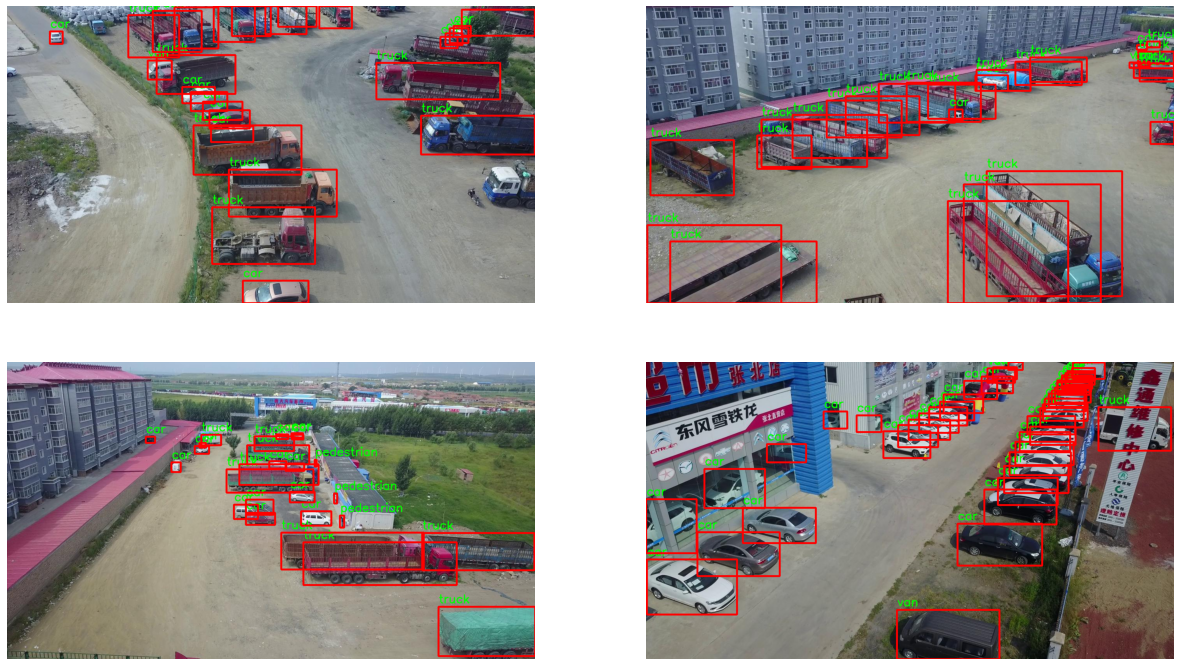

In [22]:
# Visualize a few training images.
# need to be in yolov5 directory

plot(
    image_paths="../datasets/VisDrone/visDrone2019-DET-train/images/*", 
    label_paths="../datasets/VisDrone/visDrone2019-DET-train/labels/*",
    num_samples=4,
)

In [23]:
RES_DIR = "visDrone_Model_yolov5s"

**Function to Monitor TensorBoard logs**.

In [13]:
def monitor_tensorboard():
    %load_ext tensorboard
    #%tensorboard --logdir /runs/train
    #%tensorboard --logdir C:\Ablage\Master\DeepVision\Studienarbeit\YOLOv5-vs-RCNN\yolov5\runs\train\visDrone_Model_yolov5s_25epochs
    %tensorboard --logdir C:/Ablage/Master/DeepVision/Studienarbeit/YOLOv5-vs-RCNN/yolov5/runs/train/visDrone_Model_yolov5s

## Training using YOLOV5

### Train a Small (yolov5s) Model

Training all the layers of the small model.

In [42]:
#monitor_tensorboard()

In [14]:
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.11.0+cu113 _CudaDeviceProperties(name='NVIDIA GeForce GTX 1080 Ti', major=6, minor=1, total_memory=11263MB, multi_processor_count=28)


In [15]:
torch.cuda.empty_cache()

In [16]:
%pip install -q wandb
import wandb
wandb.login(key="4e9aa3b022f7ca9d2aa5977b804a67c3818e46a7")

wandb.init(project="visDrone")

Note: you may need to restart the kernel to use updated packages.


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vanschott. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Tobias/.netrc


In [17]:
if TRAIN:
    !python train.py --data VisDrone.yaml --cfg yolov5s.yaml --epochs 15 --batch-size 40 --name visDrone_Model_yolov5s
    #!python train.py --data VisDrone.yaml --weights yolov5s.pt --epochs 15 --batch-size 40 --name visDrone_Model_yolov5s



In [1]:
#visDrone_Model_yolov5m_15epochs Training Outputs

from IPython.display import HTML, display

display(HTML('<h1>Left Bounding Boxes from Label File || Right Bounding Boxes from yolov5s_15epochs</h1>'))
display(HTML("<table><tr><td><img src='output_images/yolov5s_visDrone/val_batch2_labels.jpg'></td><td><img src='output_images/yolov5s_visDrone/val_batch2_pred.jpg'></td></tr></table>"))

,


<!-- `val_batch1_labels.jpg`
> <img src="yolov5/runs/train/visDrone_Model_yolov5s_15epochs/val_batch1_labels.jpg" width="900">  

`val_batch1_pred.jpg`
> <img src="yolov5/runs/train/visDrone_Model_yolov5s_15epochs/val_batch1_pred.jpg" width="900">   -->

`results.png` für visDrone_Model_yolov5s mit 15 epochen
> <img src='output_images/yolov5s_visDrone/results.png' width="900">  

### Detection of a static image with the trained model

In [34]:
#!python detect.py --source ../datasets/VisDrone/VisDrone2019-DET-test-dev/images/0000006_00159_d_0000001.jpg --weights /runs/train/{RES_DIR}/weights/best.pt
#!python detect.py --source ../datasets/VisDrone/VisDrone2019-DET-test-dev/images/0000006_00159_d_0000001.mp4 --weights runs/train/visDrone_Model_yolov5s/weights/best.pt

randomTestFile = random.choice(os.listdir(dataset + "/VisDrone2019-DET-val/images/"))
print(randomTestFile)
#randomTestFile = "0000117_01731_d_0000089.jpg"
visDroneYolo = "yolov5s_visDrone_15epochs"
#!python detect.py --source {dataset}/VisDrone2019-DET-test-challenge/images/{randomTestFile} --weights runs/train/visDrone_Model_yolov5s_15epochs/weights/best.pt --hide-labels
!python detect.py --source {dataset}/VisDrone2019-DET-val/images/{randomTestFile} --weights runs/train/{visDroneYolo}/weights/best.pt

0000356_02353_d_0000641.jpg


detect: weights=['runs/train/yolov5s_visDrone_15epochs/weights/best.pt'], source=../datasets/visDrone/VisDrone2019-DET-val/images/0000356_02353_d_0000641.jpg, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5  v6.1-244-g47233e1 Python-3.9.12 torch-1.11.0+cu113 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11264MiB)

Fusing layers... 
Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.9 GFLOPs
image 1/1 C:\Ablage\Master\DeepVision\Studienarbeit\YOLOv5-vs-RCNN\datasets\VisDrone\VisDrone2019-DET-val\images\0000356_02353_d_0000641.jpg: 384x640 8 pedestrians, 6 peoples, 25 cars, 1 van, 4 motors, Done. (0.010s)
Speed: 0.0ms pre-process, 10.0ms inference, 4.2

In [2]:
#visDrone_Model_yolov5s_15epochs 

from IPython.display import HTML, display

display(HTML('<h1>Left Bounding Boxes from Label File || Right Bounding Boxes from yolov5s_15epochs</h1>'))
display(HTML("<table><tr><td><img src='output_images/yolov5s_visDrone/val_batch3_labels.jpg'></td><td><img src='output_images/yolov5s_visDrone/val_batch3_pred.jpg'></td></tr></table>"))

,


`0000006_00159_d_0000001.jpg` Random Test Image
> <img src="yolov5/runs/detect/exp10/0000350_05500_d_0000183.jpg" width="900">  




### Detection of a static mp4-Video with the trained model

In [20]:
#!python detect.py --source {dataset}/Test_video/0000005_7DbGa5U4.mp4 --weights {yolov5sDir}/weights/best.pt --hide-labels

In [58]:
from IPython.display import Video

Video("../datasets/visDrone/Test_video/0000005_7DbGa5U4.mp4")
#Video(dataset + "/Test_video/0000005_7DbGa5U4_detected.mp4", embed=True)


### VALIDATION


In [ ]:
#Ohne labels -> in plots.py Zeile 84 auskommentieren
!python val.py --weights {yolov5sDir}/weights/best.pt --data visDrone.yaml --half


### TEST

In [ ]:
#!python val.py --weights {yolov5sDir}/weights/best.pt --data visDrone.yaml --half --task test

## Training using  Medium Model

In [ ]:
if TRAIN:
    !python train.py --data VisDrone.yaml --cfg yolov5m.yaml --epochs 15 --batch-size 16 --name visDrone_Model_yolov5m


# VOC
# for b, m in zip([40, 16], ['yolov5s', 'yolov5x']):  # batch, model
#   !python train.py --batch {b} --weights {m}.pt --data VOC.yaml --epochs 50 --img 512 --hyp hyp.VOC.yaml --project VOC --name {m} --cache

In [85]:
!python val.py --weights {yolov5mDir}/weights/best.pt --data visDrone.yaml --half

val: data=C:\Ablage\Master\DeepVision\Studienarbeit\YOLOv5-vs-RCNN\yolov5\data\visDrone.yaml, weights=['runs/train/visDrone_Model_yolov5m_15epochs/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs\val, name=exp, exist_ok=False, half=True, dnn=False
YOLOv5  v6.1-227-ga6e99e4 Python-3.9.12 torch-1.11.0+cu113 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11264MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20889303 parameters, 0 gradients, 48.1 GFLOPs

val: Scanning 'C:\Ablage\Master\DeepVision\Studienarbeit\YOLOv5-vs-RCNN\datasets\VisDrone\VisDrone2019-DET-val\labels.cache' images and labels... 548 found, 0 missing, 0 empty, 0 corrupt: 100%|██████████| 548/548 [00:00<?, ?it/s]
val: Scanning 'C:\Ablage\Master\DeepVision\Studienarbeit\YOLOv5-vs-RCNN\datasets\VisDrone\VisDrone2019-DET-val\labels.cache' images a

In [3]:
#visDrone_Model_yolov5m_15epochs 

from IPython.display import HTML, display

display(HTML('<h1>Left Bounding Boxes from Label File || Right Bounding Boxes from yolov5m_15epochs</h1>'))
display(HTML("<table><tr><td><img src='output_images/yolov5m_visDrone/val_batch1_labels.jpg'></td><td><img src='output_images/yolov5m_visDrone/val_batch1_pred.jpg'></td></tr></table>"))

,


<!-- `val_batch1_labels.jpg`
> <img src="yolov5/runs/train/visDrone_Model_yolov5m_15epochs/val_batch1_labels.jpg" width="900">  

`val_batch1_pred.jpg`
> <img src="yolov5/runs/train/visDrone_Model_yolov5m_15epochs/val_batch1_pred.jpg" width="900">   -->

`results.png` für visDrone_Model_yolov5s mit 15 epochen
> <img src='output_images/yolov5m_visDrone/results.png' width="900">  

In [4]:
#visDrone_Model_yolov5m_15epochs 

from IPython.display import HTML, display

display(HTML('<h1>Left Bounding Boxes from Label File || Right Bounding Boxes from yolov5m_15epochs</h1>'))
display(HTML("<table><tr><td><img src='output_images/yolov5m_visDrone/val_batch2_labels.jpg'></td><td><img src='output_images/yolov5m_visDrone/val_batch2_pred.jpg'></td></tr></table>"))

,


In [5]:
#visDrone_Model_yolov5m_15epochs 

from IPython.display import HTML, display

display(HTML('<h1>Left: visDrone_Model_yolov5s_15epochs 40 batch size  || Right: visDrone_Model_yolov5m_15epochs 16 batch size</h1>'))
display(HTML("<table><tr><td><img src='output_images/yolov5s_visDrone/results.png'></td><td><img src='output_images/yolov5m_visDrone/results.png'></td></tr></table>"))

,
